In [1]:
import os
import argparse

import numpy as np
import torch as th
import torch.nn.functional as F
import time
from RePaint import conf_mgt
from RePaint.utils import yamlread
from RePaint.guided_diffusion import dist_util

In [2]:
print(os.getcwd())
os.chdir("..")
print(os.getcwd())

D:\M.Arch\MastersThesis\ArchGaussian-Project\arch-gaussian\RePaint
D:\M.Arch\MastersThesis\ArchGaussian-Project\arch-gaussian


In [3]:
from RePaint.guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args,
)  # noqa: E402

In [4]:
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample


## conf

In [5]:
conf_path = "./Repaint/confs/test.yml"
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread(conf_path))

## main

In [6]:
device = dist_util.dev(conf.get('device'))
print(device)

cuda


In [7]:
model, diffusion = create_model_and_diffusion(
    **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)
print(conf.use_fp16)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()
show_progress = conf.show_progress

True


In [8]:
def model_fn(x, t, y=None, gt=None, **kwargs):
    assert y is not None
    return model(x, t, y if conf.class_cond else None, gt=gt)


In [9]:
dset = 'eval'
eval_name = conf.get_default_eval_name()
print(f"eval_name = {eval_name}")

dl = conf.get_dataloader(dset=dset, dsName=eval_name)

eval_name = paper_face_mask


### one loop

In [10]:
batch = next(iter(dl))
print(batch.keys())

dict_keys(['GT', 'GT_name', 'gt_keep_mask'])


In [11]:
print(batch['GT'].shape)
print(batch['GT'].device)

torch.Size([1, 3, 256, 256])
cpu


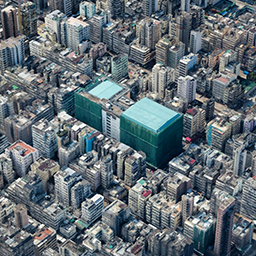

In [12]:
from PIL import Image
import numpy as np

def tensor_to_image(tensor: th.Tensor):
    img_arr = tensor.detach().cpu().squeeze().numpy() * 0.5 + 0.5  # remap to 0 to 1
    pil_image = Image.fromarray((img_arr * 255).astype('uint8').transpose((1, 2, 0)))
    return pil_image

tensor_to_image(batch['GT'])

In [13]:
for k in batch.keys():
    if isinstance(batch[k], th.Tensor):
        batch[k] = batch[k].to(device)


In [14]:
print(batch['GT'].device)

cuda:0


In [15]:
model_kwargs = {}

model_kwargs["gt"] = batch['GT']

gt_keep_mask = batch.get('gt_keep_mask')
if gt_keep_mask is not None:
    model_kwargs['gt_keep_mask'] = gt_keep_mask

batch_size = model_kwargs["gt"].shape[0]

if conf.cond_y is not None:
    print(f"conf cond_y is not None")
    classes = th.ones(batch_size, dtype=th.long, device=device)
    model_kwargs["y"] = classes * conf.cond_y
else:
    print(f"conf cond_y is None")
    classes = th.randint(
        low=0, high=NUM_CLASSES, size=(batch_size,), device=device
    )
    print(classes)
    model_kwargs["y"] = classes
model_kwargs.keys()

conf cond_y is None
tensor([99], device='cuda:0')


dict_keys(['gt', 'gt_keep_mask', 'y'])

In [16]:
print(f"use_ddim = {conf.use_ddim}")
sample_fn = (
    diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
)


use_ddim = False


In [17]:
# full loop
result = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=None,
    device=device,
    progress=show_progress,
    return_all=True,
    conf=conf
)

  0%|          | 0/2285 [00:00<?, ?it/s]

[-] t_last = 124, t_cur = 123
[-] t_last = 123, t_cur = 122
[-] t_last = 122, t_cur = 121
[-] t_last = 121, t_cur = 120
[-] t_last = 120, t_cur = 119
[-] t_last = 119, t_cur = 118
[-] t_last = 118, t_cur = 117
[-] t_last = 117, t_cur = 116
[-] t_last = 116, t_cur = 115
[-] t_last = 115, t_cur = 114
[-] t_last = 114, t_cur = 113
[-] t_last = 113, t_cur = 112
[-] t_last = 112, t_cur = 111
[-] t_last = 111, t_cur = 110
[-] t_last = 110, t_cur = 111
[-] t_last = 111, t_cur = 112
[-] t_last = 112, t_cur = 113
[-] t_last = 113, t_cur = 114
[-] t_last = 114, t_cur = 115
[-] t_last = 115, t_cur = 116
[-] t_last = 116, t_cur = 117
[-] t_last = 117, t_cur = 118
[-] t_last = 118, t_cur = 119
[-] t_last = 119, t_cur = 120
[-] t_last = 120, t_cur = 119
[-] t_last = 119, t_cur = 118
[-] t_last = 118, t_cur = 117
[-] t_last = 117, t_cur = 116
[-] t_last = 116, t_cur = 115
[-] t_last = 115, t_cur = 114
[-] t_last = 114, t_cur = 113
[-] t_last = 113, t_cur = 112
[-] t_last = 112, t_cur = 111
[-] t_last

In [18]:
result.keys()

dict_keys(['sample', 'pred_xstart', 'gt'])

### sample_fn 拆解

In [122]:
shape = (batch_size, 3, conf.image_size, conf.image_size)
print(shape)

(1, 3, 256, 256)


tensor(-4.1084, device='cuda:0')
tensor(4.3460, device='cuda:0')


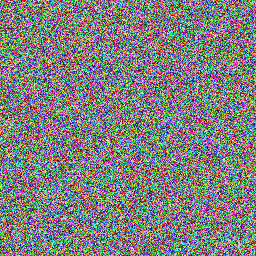

In [123]:
image_after_step = th.randn(*shape, device=device)
print(th.min(image_after_step))
print(th.max(image_after_step))
tensor_to_image(image_after_step)

In [124]:
pred_xstart = None

In [125]:
from RePaint.guided_diffusion.scheduler import get_schedule_jump
times = get_schedule_jump(**conf.schedule_jump_params)
time_pairs = list(zip(times[:-1], times[1: ]))
print(len(time_pairs))

2285


In [126]:
t_last, t_cur = time_pairs[0]
print(t_last, t_cur)

124 123


In [127]:
t_last_t = th.tensor([t_last] * shape[0], device=device)
t_last_t

tensor([124], device='cuda:0')

In [131]:

with th.no_grad():
    out = diffusion.p_sample(
        model,
        image_after_step,
        t_last_t,
        clip_denoised=True,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=model_kwargs,
        conf=conf,
        pred_xstart=pred_xstart
    )


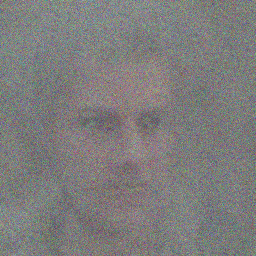

In [132]:
tensor_to_image(out["pred_xstart"])

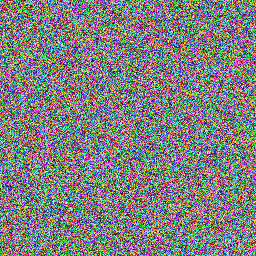

In [130]:
tensor_to_image(out['sample'])

In [101]:
image_after_step = out["sample"]
pred_xstart = out["pred_xstart"]

## 继续分解

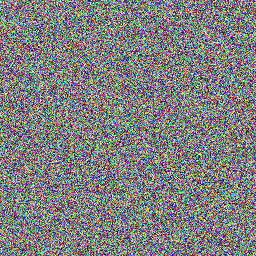

In [133]:
noise = th.randn_like(image_after_step)
tensor_to_image(noise)

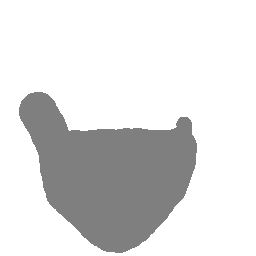

In [134]:
gt_keep_mask = model_kwargs.get('gt_keep_mask')
tensor_to_image(gt_keep_mask)

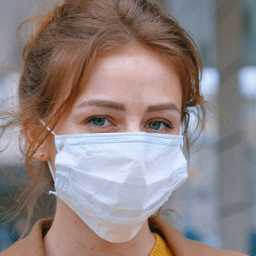

In [135]:
gt = model_kwargs['gt']
tensor_to_image(gt)

In [136]:
from RePaint.guided_diffusion.gaussian_diffusion import _extract_into_tensor
print(diffusion.alphas_cumprod.shape)
print(t_last_t)
alpha_cumprod = _extract_into_tensor(diffusion.alphas_cumprod, t_last_t, image_after_step.shape)
tensor_to_image(alpha_cumprod)
print(th.min(alpha_cumprod))
print(th.max(alpha_cumprod))

(250,)
tensor([124], device='cuda:0')
tensor(0.0802, device='cuda:0')
tensor(0.0802, device='cuda:0')


False
gt_weight = 0.28317442536354065
noise_weight = 0.9590684175491333


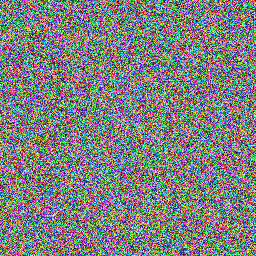

In [137]:
print(conf.inpa_inj_sched_prev_cumnoise)
if conf.inpa_inj_sched_prev_cumnoise:
    
    weighed_gt = diffusion.get_gt_noised(gt, int(t_last_t[0].item()))
else:
    gt_weight = th.sqrt(alpha_cumprod)
    print(f"gt_weight = {th.min(gt_weight)}")
    gt_part = gt_weight * gt

    noise_weight = th.sqrt((1 - alpha_cumprod))
    print(f"noise_weight = {th.min(noise_weight)}")
    noise_part = noise_weight * th.randn_like(image_after_step)

    weighed_gt = gt_part + noise_part
tensor_to_image(weighed_gt)


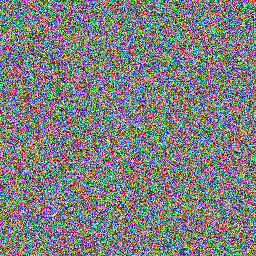

In [138]:

x = (
    gt_keep_mask * (
        weighed_gt
    )
    +
    (1 - gt_keep_mask) * (
        image_after_step
    )
)
tensor_to_image(x)

In [139]:
out = diffusion.p_mean_variance(
            model,
            x,
            t_last_t,
            clip_denoised=None,
            denoised_fn=None,
            model_kwargs=model_kwargs,
        )
print(out.keys())

dict_keys(['mean', 'variance', 'log_variance', 'pred_xstart'])


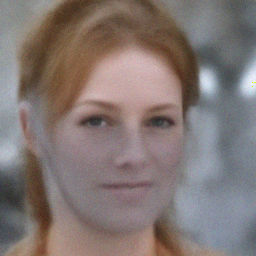

In [140]:
tensor_to_image(out['pred_xstart'])

In [141]:
nonzero_mask = (
    (t_last_t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
) 


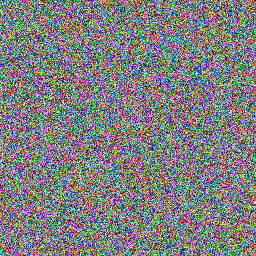

In [142]:
sample = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
tensor_to_image(sample)